# **安裝所需的套件**

In [1]:
!pip install tensorflow pandas numpy matplotlib scikit-learn

**使用 OpenCV讀取圖片，並將其轉換為適合 CNN 訓練的格式**

In [2]:
import os

image_folder = '/kaggle/input/wm811k-silicon-wafer-map-dataset-image/WM811k_Dataset'

# 列出資料夾中的所有檔案和子資料夾
folders = [f for f in os.listdir(image_folder) if os.path.isdir(os.path.join(image_folder, f))]
print(folders)

['random', 'Local', 'Donut', 'Edge Local', 'Edge Ring', 'Center', 'none', 'Scratch', 'near full']


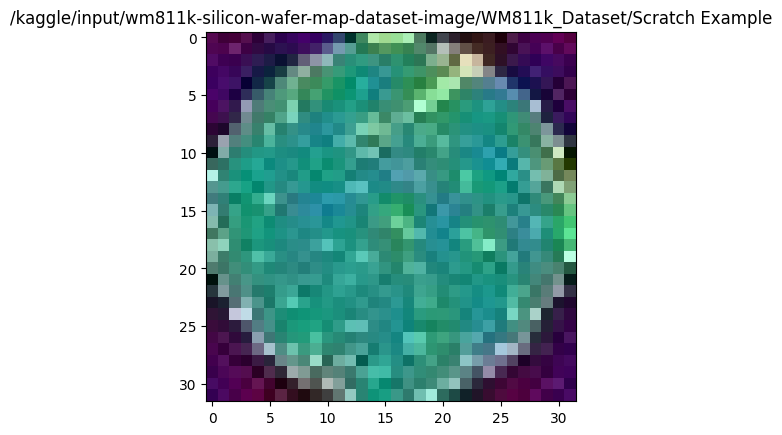

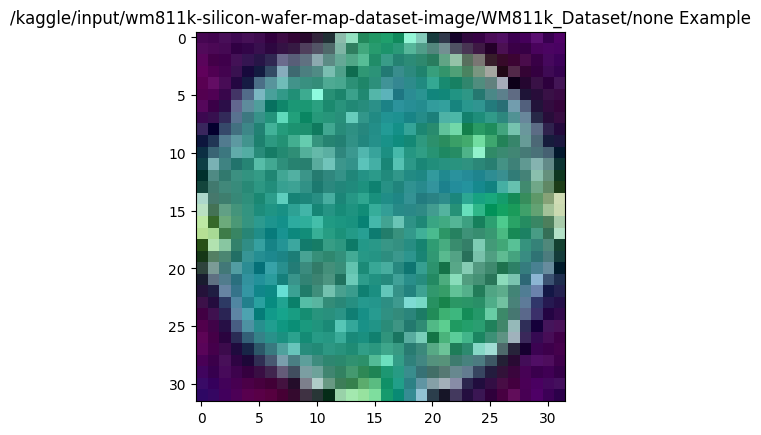

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 選擇包含有缺陷和正常圖像的資料夾
defective_folder = '/kaggle/input/wm811k-silicon-wafer-map-dataset-image/WM811k_Dataset/Scratch'  # 有刮痕的圖像
normal_folder = '/kaggle/input/wm811k-silicon-wafer-map-dataset-image/WM811k_Dataset/none'  # 表示無缺陷的圖像

# 讀取資料夾中的圖片
defective_images = os.listdir(os.path.join(image_folder, defective_folder))
normal_images = os.listdir(os.path.join(image_folder, normal_folder))

# 顯示一張有缺陷的圖片範例
image_path = os.path.join(image_folder, defective_folder, defective_images[0])
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'{defective_folder} Example')
plt.show()

# 顯示一張正常的圖片範例
image_path = os.path.join(image_folder, normal_folder, normal_images[0])
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'{normal_folder} Example')
plt.show()

# **圖像預處理**

In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 定義圖片大小
image_size = (64, 64)

# 讀取並處理圖像
def load_images_from_folder(folder, label, image_size=(64, 64)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img) / 255.0  # 歸一化
        images.append(img_array)
        labels.append(label)
    return images, labels

# 讀取有缺陷和無缺陷的圖像
defective_images, defective_labels = load_images_from_folder(defective_folder, 1, image_size)
normal_images, normal_labels = load_images_from_folder(normal_folder, 0, image_size)

# 合併所有圖像與標籤
images = np.array(defective_images + normal_images)
labels = np.array(defective_labels + normal_labels)

# 分割資料集為訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# 將標籤轉換為 one-hot 編碼
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


# **建立 CNN 模型**

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# 建立卷積神經網絡模型
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),  # 卷積層
    MaxPooling2D(2, 2),  # 池化層
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # 輸出層，二分類問題
])

# 編譯模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 查看模型架構
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,410 (6.20 MB)

 Trainable params: 1,625,410 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

# **訓練 CNN 模型**

In [6]:
# 訓練模型
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.5299 - loss: 0.9935 - val_accuracy: 0.4750 - val_loss: 0.7353
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.5382 - loss: 0.7032 - val_accuracy: 0.5250 - val_loss: 0.6860
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5405 - loss: 0.6870 - val_accuracy: 0.4750 - val_loss: 0.6830
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.5008 - loss: 0.6730 - val_accuracy: 0.9750 - val_loss: 0.6653
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8876 - loss: 0.6519 - val_accuracy: 0.8750 - val_loss: 0.6387
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.7329 - loss: 0.6227 - val_accuracy: 0.9500 - val_loss: 0.5952
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9594 - loss: 0.5484 - val_accuracy: 0.7500 - val_loss: 0.5541
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9466 - loss: 0.4674 - val_accuracy: 0.9250 - val_loss:

# **評估模型**

In [7]:
# 評估模型在測試集上的表現
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"測試準確度: {test_acc * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9187 - loss: 0.2443
測試準確度: 92.50%


# **視覺化訓練過程**

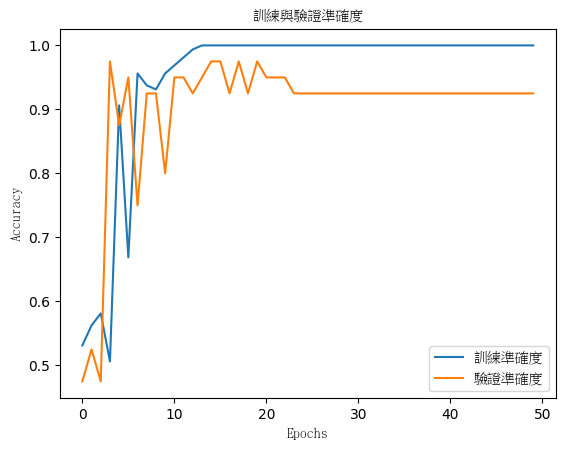

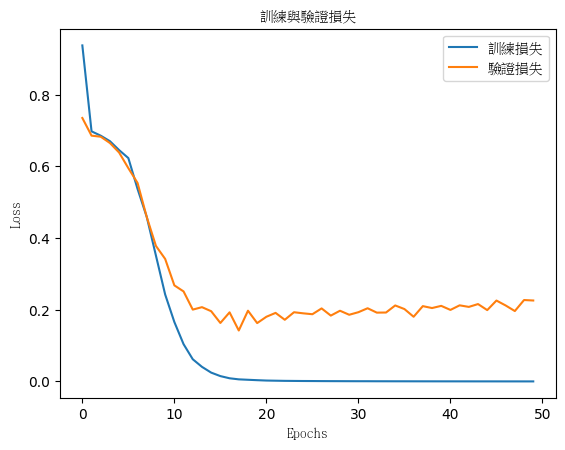

In [8]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 設定字型
font_path = "/kaggle/input/fontchinese/Open_Data/Fonts/TW-Sung-98_1.ttf"
font_prop = font_manager.FontProperties(fname=font_path)

# 畫出訓練過程中的損失和準確度
plt.plot(history.history['accuracy'], label='訓練準確度')
plt.plot(history.history['val_accuracy'], label='驗證準確度')
plt.title('訓練與驗證準確度', fontproperties=font_prop)
plt.xlabel('Epochs', fontproperties=font_prop)
plt.ylabel('Accuracy', fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.show()

# 畫出訓練過程中的損失和驗證損失
plt.plot(history.history['loss'], label='訓練損失')
plt.plot(history.history['val_loss'], label='驗證損失')
plt.title('訓練與驗證損失', fontproperties=font_prop)
plt.xlabel('Epochs', fontproperties=font_prop)
plt.ylabel('Loss', fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.show()


# **預測**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


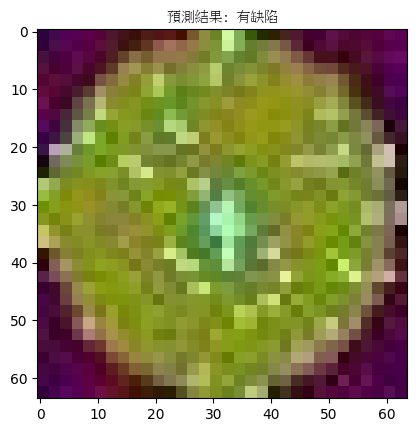

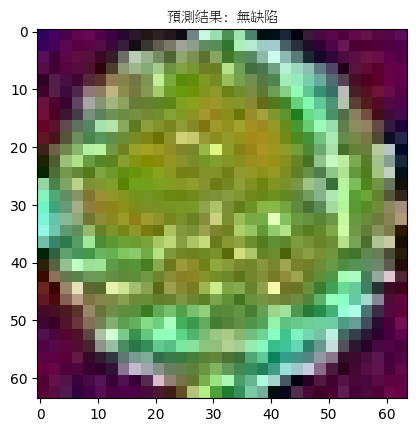

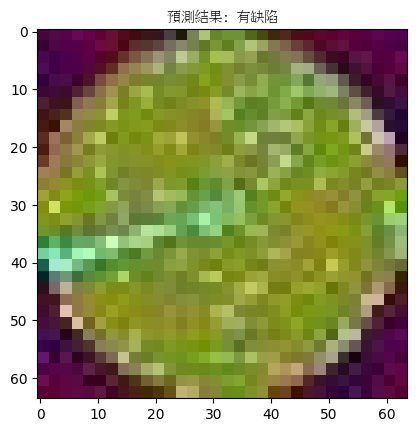

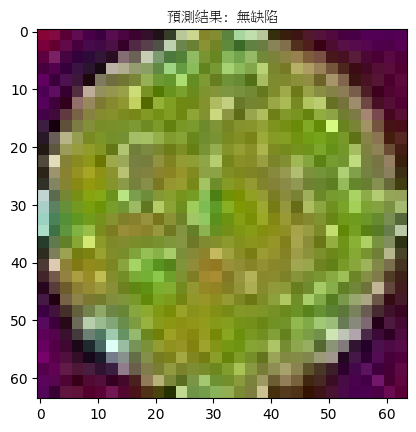

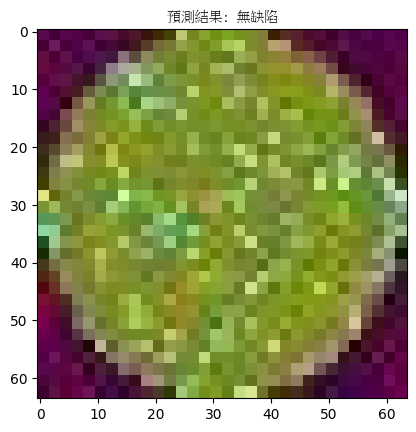

In [9]:
# 使用訓練好的模型進行預測
predictions = model.predict(X_test)

# 顯示前幾張圖片與預測結果
for i in range(5):
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    prediction = np.argmax(predictions[i])  # 預測的結果，0為無缺陷，1為有缺陷
    plt.title(f"預測結果: {'有缺陷' if prediction == 1 else '無缺陷'}", fontproperties=font_prop)
    plt.show()
